In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Loading data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dict = pd.read_pickle('drive/MyDrive/gdrive/Proj2_data/data1/train.pickle')
test_dict = pd.read_pickle('drive/MyDrive/gdrive/Proj2_data/data1/test.pickle')
valid_dict = pd.read_pickle('drive/MyDrive/gdrive/Proj2_data/data1/valid.pickle')
labels = pd.read_csv('drive/MyDrive/gdrive/Proj2_data/data1/label_names.csv')

In [ ]:
## Explore labels

labels.head()
classes = labels.ClassId.unique()


coords -> 34799
labels -> 34799
features -> 34799
sizes -> 34799
tmp created {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0}


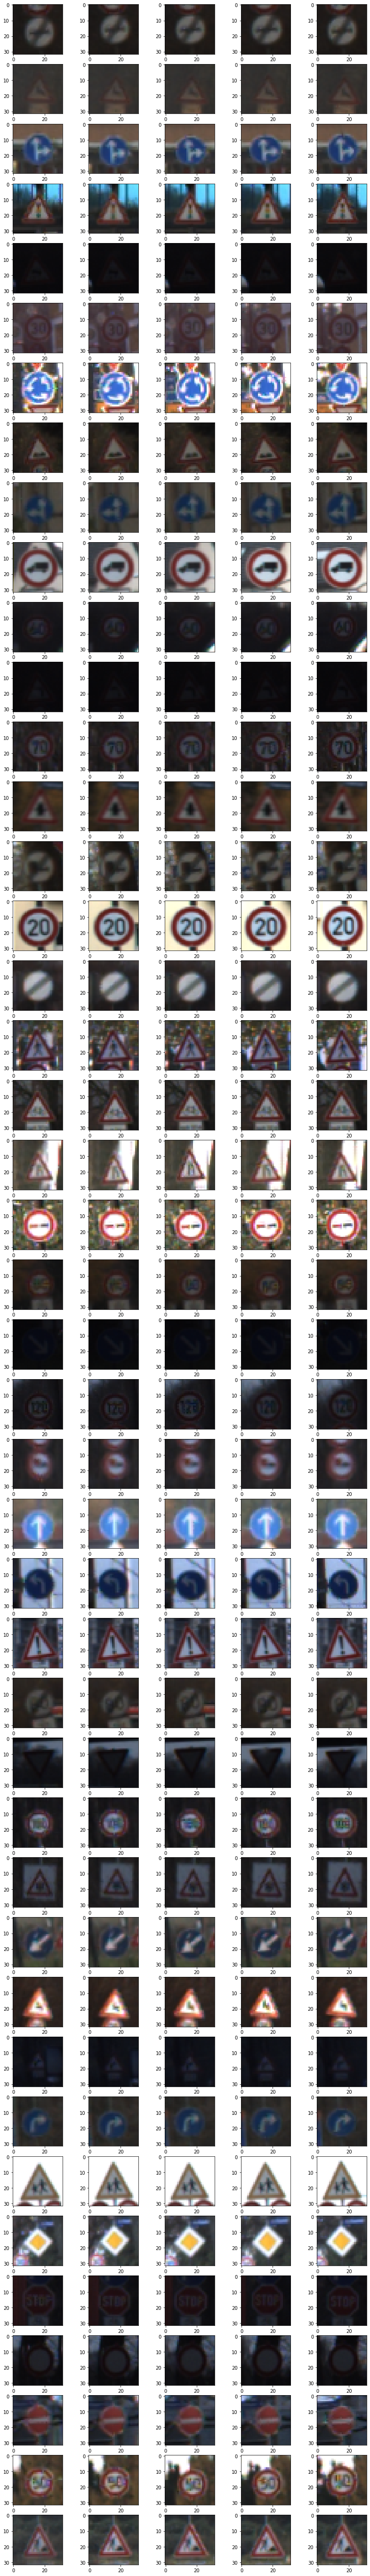

In [ ]:
## Explore train data

for key, value in train_dict.items():
  print(key, '->', len(value))

max_count = 5
max_classes = len(classes)
fig = plt.figure(figsize=(14, 100))
tmp = {}
for i in classes:
  tmp[str(i)] = 0

counter = 1
print('tmp created {}'.format(tmp))
for index, img in enumerate(train_dict['features']):
  if tmp[str(train_dict['labels'][index])] < max_count:
    tmp[str(train_dict['labels'][index])] += 1
    ax = fig.add_subplot(max_classes, max_count, counter)
    _ = plt.imshow(img)
    if counter == max_classes * max_count:
      break
    counter += 1
plt.savefig('5_of_all.png')

In [ ]:
tmp = {}
for i in classes:
  tmp[str(i)] = 0

for i in train_dict['labels']:
  tmp[str(i)] += 1

x = []
y = []
for i, j in tmp.items():
  x.append(i)
  y.append(j)

n = len(y)
for i in range(n-1):
  for j in range(0, n-i-1): 
    if y[j] > y[j+1] : 
      y[j], y[j+1] = y[j+1], y[j]
      x[j], x[j+1] = x[j+1], x[j]

fig = plt.figure(figsize=(18, 5))
fig.add_subplot(1, 1, 1)
_ = plt.bar(x, y)
plt.savefig('labbels_count.png')

In [ ]:
# The classes have diffrent number of images so we do this 
y = np.array(y)
mean_class_count = y.sum() // len(y)
print('mean:', mean_class_count)
sec_quantile_class_count = int(np.quantile(y, .50))
print('quatile:', sec_quantile_class_count)

# I choose sec_quantile_class_count
class_count = sec_quantile_class_count
print('miane:', class_count)

mean: 809
quatile: 540
miane: 540


**we now add dup images**

In [ ]:
# load train to dict
tmp = {}
for i in classes:
  tmp[str(i)] = []

for index, img in enumerate(train_dict['features']):
  tmp[str(train_dict['labels'][index])].append(img)

train_data = tmp

In [ ]:
for _class, images in train_data.items():
  l = len(images)
  l1 = l
  while l1 < class_count:
    print('images size before make duplicates:', l1)
    train_data[_class] = np.concatenate((train_data[_class], images), axis=0)
    l1 += l
  np.random.shuffle(train_data[_class])
  train_data[_class] = np.array(train_data[_class][:class_count])

for _class, images in train_data.items():
  print('class', _class, 'have', len(images), 'images with shape', images.shape)

images size before make duplicates: 180
images size before make duplicates: 360
images size before make duplicates: 360
images size before make duplicates: 360
images size before make duplicates: 180
images size before make duplicates: 360
images size before make duplicates: 300
images size before make duplicates: 270
images size before make duplicates: 330
images size before make duplicates: 450
images size before make duplicates: 240
images size before make duplicates: 480
images size before make duplicates: 210
images size before make duplicates: 420
images size before make duplicates: 480
images size before make duplicates: 240
images size before make duplicates: 480
images size before make duplicates: 390
images size before make duplicates: 210
images size before make duplicates: 420
images size before make duplicates: 360
images size before make duplicates: 330
images size before make duplicates: 180
images size before make duplicates: 360
images size before make duplicates: 270


# **شبکه** 1

In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

(23220, 32, 32, 3)
(23220,)


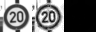

(32, 32, 1)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def to_grey(image):
  out = [[0.0 for i in range(len(image))] for i in range(len(image))]
  qq = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      q = image[i][j][0] * 0.299 + image[i][j][1] * 0.587 + image[i][j][2] * 0.114
      out[i][j] = [q]
      if q < 1:
        qq += 1
  return np.array(out), qq


def histogram_equalize(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equ = clache.apply(np.uint8(image))
  return equ


def normalization(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,1))

sample = trainX[0]
grey, _ = to_grey(sample)
# cv2_imshow(cv2.resize(grey, (100, 100)))

equ = histogram_equalize(grey)
# cv2_imshow(cv2.resize(equ, (100, 100)))

normed = normalization(equ)
# cv2_imshow(cv2.resize(normed, (100, 100)))

fig = plt.figure(figsize=(14, 5))
fig.add_subplot(1, 4, 1)
plt.title('actual image')
plt.imshow(sample)

fig.add_subplot(1, 4, 2)
plt.title('after grey scaling')
plt.imshow(grey.squeeze(), cmap='Greys')

fig.add_subplot(1, 4, 3)
plt.title('after equalization scaling')
plt.imshow(equ.squeeze(), cmap='Greys')

fig.add_subplot(1, 4, 4)
plt.title('after normalization scaling')
_ = plt.imshow(normed.squeeze())

stk = np.hstack((grey.squeeze(), equ.squeeze(), normed.squeeze()))
cv2_imshow(stk)

print(normed.shape)


**Doing above regularizations to datas**  
do not run bellow cell multiple times


In [ ]:
## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Gray scaling
  grey, _ = to_grey(img)
  # Histogram equalization
  equ = histogram_equalize(grey)
  # Normalization
  normed = normalization(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Gray scaling
  grey, _ = to_grey(img)
  # Histogram equalization
  equ = histogram_equalize(grey)
  # Normalization
  normed = normalization(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Gray scaling
  grey, _ = to_grey(img)
  # Histogram equalization
  equ = histogram_equalize(grey)
  # Normalization
  normed = normalization(equ)
  tmp.append(normed)

testX = np.array(tmp)

trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)


In [ ]:
trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

In [ ]:
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)


In [ ]:
batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32)
    plt.imshow(img)
  else:
    break

In [ ]:
batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

In [ ]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        2

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# checkpointer = tf.keras.callbacks.ModelCheckpoint(
#     filepath="best_weights.hdf5", 
#     monitor = 'val_accuracy',
#     verbose=1, 
#     save_best_only=True
# )

# We Don't need above callback because of below one 

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

In [ ]:
for i in image_data:
  print(i[0].shape, len(i[1]))
  break

(128, 32, 32, 1) 128


In [ ]:
history = model.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

Epoch 1/20
182/182 [==============================] - 8s 44ms/step - loss: 1.8382 - accuracy: 0.5241 - val_loss: 6.6387 - val_accuracy: 0.0209
Epoch 2/20
182/182 [==============================] - 8s 42ms/step - loss: 0.3593 - accuracy: 0.9145 - val_loss: 10.1061 - val_accuracy: 0.0204
Epoch 3/20
182/182 [==============================] - 8s 43ms/step - loss: 0.1365 - accuracy: 0.9670 - val_loss: 4.3411 - val_accuracy: 0.1728
Epoch 4/20
182/182 [==============================] - 8s 42ms/step - loss: 0.0783 - accuracy: 0.9819 - val_loss: 0.2912 - val_accuracy: 0.9231
Epoch 5/20
182/182 [==============================] - 8s 43ms/step - loss: 0.0552 - accuracy: 0.9865 - val_loss: 0.1129 - val_accuracy: 0.9635
Epoch 6/20
182/182 [==============================] - 8s 43ms/step - loss: 0.0434 - accuracy: 0.9879 - val_loss: 0.1223 - val_accuracy: 0.9655
Epoch 7/20
182/182 [==============================] - 8s 43ms/step - loss: 0.0396 - accuracy: 0.9896 - val_loss: 0.2026 - val_accuracy: 0.946

In [ ]:
model.save("first_model.h5")

In [ ]:
losses_df = pd.DataFrame({
    'loss': history.history['loss'],
    'validation_loss': history.history['val_loss']
})

losses_df.plot()

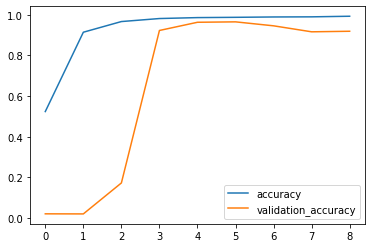

In [ ]:
accuracy_df = pd.DataFrame({
    'accuracy': history.history['accuracy'],
    'validation_accuracy': history.history['val_accuracy']
})

accuracy_df.plot()

In [ ]:
### Doinng with 3 channel 

# شبکه 2 

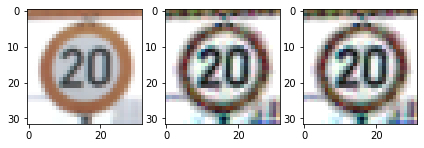

In [ ]:
import cv2

def equalizeRGB(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  r, g, b = cv2.split(image)
  equ1 = clache.apply(np.uint8(r))
  equ2 = clache.apply(np.uint8(g))
  equ3 = clache.apply(np.uint8(b))
  equ = cv2.merge((equ1, equ2, equ3))
  return equ.reshape(32, 32, 3)

def normalizationRGB(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,3))

fig = plt.figure(figsize=(7, 4))
img = trainX[0]
fig.add_subplot(1, 3, 1)
_ = plt.imshow(img)
img = equalizeRGB(img)
fig.add_subplot(1, 3, 2)
_ = plt.imshow(img)
img = normalizationRGB(img)
fig.add_subplot(1, 3, 3)
_ = plt.imshow(img)

(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 3) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 3) testY shape:  (12630, 43)
********************
********************
********************
Epoch 1/20
182/182 [==============================] - 14s 78ms/step - loss: 1.7111 - accuracy: 0.5575 - val_loss: 8.6092 - val_accuracy: 0.0068
Epoch 2/20
182/182 [==============================] - 14s 77ms/step - loss: 0.2911 - accuracy: 0.9321 - val_loss: 7.3932 - val_accuracy: 0.0086
Epoch 3/20
182/182 [==============================] - 14s 76ms/step - loss: 0.1055 - accuracy: 0.9762 - val_loss: 1.0005 - val_accuracy: 0.7494
Epoch 4/20
182/182 [==============================] - 14s 76ms/step - loss: 0.0717 - accurac

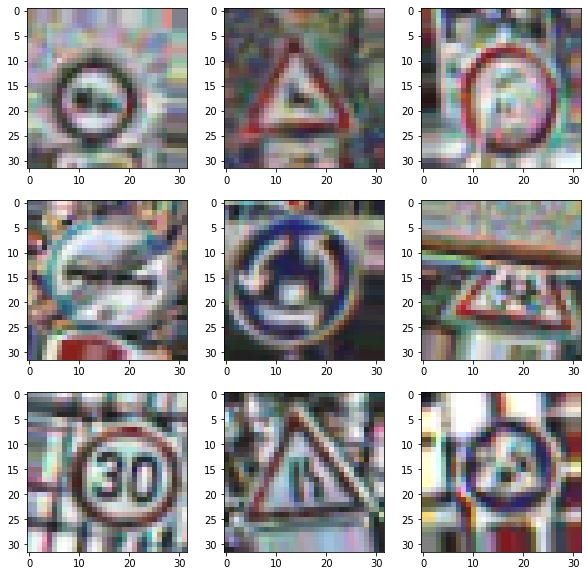

In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Histogram equalization
  equ = equalizeRGB(img)
  # Normalization
  normed = normalizationRGB(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Histogram equalization
  equ = equalizeRGB(img)
  # Normalization
  normed = normalizationRGB(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Histogram equalization
  equ = equalizeRGB(img)
  # Normalization
  normed = normalizationRGB(equ)
  tmp.append(normed)

testX = np.array(tmp)

print('*' * 20)

trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32, 3)
    plt.imshow(img)
  else:
    break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

In [ ]:
model1.save('RGB_CNN.h5')

<Figure size 432x288 with 0 Axes>

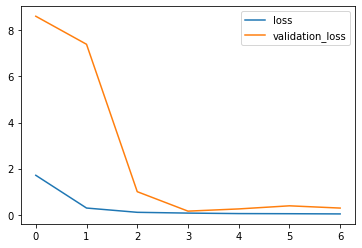

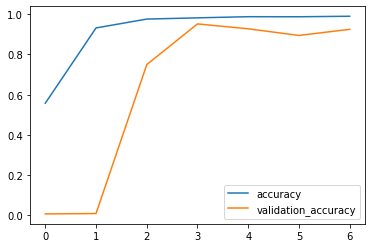

In [ ]:
plt.figure(1)
losses_df1 = pd.DataFrame({
    'loss': history1.history['loss'],
    'validation_loss': history1.history['val_loss']
})

_ = losses_df1.plot()

plt.figure(2)
losses_df1 = pd.DataFrame({
    'accuracy': history1.history['accuracy'],
    'validation_accuracy': history1.history['val_accuracy']
})

_ = losses_df1.plot()


# 3شبکه 

In [ ]:
import cv2

def equalizeRG(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  r, g, b = cv2.split(image)
  equ1 = clache.apply(np.uint8(r))
  equ2 = clache.apply(np.uint8(g))
  equ = cv2.merge((equ1, equ2))
  return equ.reshape(32, 32, 2)

def normalizationRG(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,2))


In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Histogram equalization
  equ = equalizeRG(img)
  # Normalization
  normed = normalizationRG(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Histogram equalization
  equ = equalizeRG(img)
  # Normalization
  normed = normalizationRG(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Histogram equalization
  equ = equalizeRG(img)
  # Normalization
  normed = normalizationRG(equ)
  tmp.append(normed)

testX = np.array(tmp)

print('*' * 20)



trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 2) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 2) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 2) testY shape:  (12630, 43)
********************
********************
********************


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (23220, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (4410, 32, 32, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
182/182 [==============================] - 12s 64ms/step - loss: 1.8323 - accuracy: 0.5320 - val_loss: 5.0445 - val_accuracy: 0.0243
Epoch 2/20
182/182 [==============================] - 12s 63ms/step - loss: 0.3107 - accuracy: 0.9265 - val_loss: 7.5595 - val_accuracy: 0.0188
Epoch 3/20
182/182 [==============================] - 12s 63ms/step - loss: 0.1118 - accuracy: 0.9752 - val_loss: 0.9737 - val_accuracy: 0.7272
Epoch 4/20
182/182 [==============================] - 11s 63ms/step - loss: 0.0699 - accuracy: 0.9830 - val_loss: 0.3463 - val_accuracy: 0.8957
Epoch 5/20
182/182 [==============================] - 11s 63ms/step - loss: 0.0692 - accuracy: 0.9811 - val_loss: 0.3980 - val_accuracy: 0.8830
Epoch 6/20
182/182 [==============================] - 11s 63ms/step - loss: 0.0423 - accuracy: 0.9891 - val_loss: 0.2591 - val_accuracy: 0.9297
Epoch 7/20
182/182 [==============================] - 12s 64ms/step - loss: 0.0272 - accuracy: 0.9931 - val_loss: 0.1080 - val_accuracy:

<Figure size 432x288 with 0 Axes>

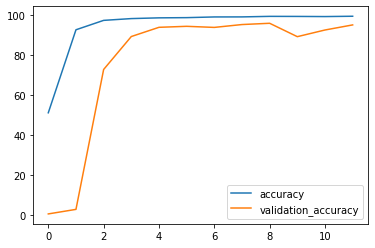

In [ ]:
plt.figure(1)
losses_df1 = pd.DataFrame({
    'loss': history2.history['loss'],
    'validation_loss': history2.history['val_loss']
})

_ = losses_df1.plot()

plt.figure(2)
losses_df1 = pd.DataFrame({
    'accuracy': np.array(history2.history['accuracy']) *100 ,
    'validation_accuracy': np.array(history2.history['val_accuracy']) *100
})

_ = losses_df1.plot()


# شبکه **4**

In [ ]:
import cv2

def equalizeR(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  r, g, b = cv2.split(image)
  equ1 = clache.apply(np.uint8(r))
  return equ1.reshape(32, 32, 1)

def normalizationR(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32, 32, 1))


In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Histogram equalization
  equ = equalizeR(img)
  # Normalization
  normed = normalizationR(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Histogram equalization
  equ = equalizeR(img)
  # Normalization
  normed = normalizationR(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Histogram equalization
  equ = equalizeR(img)
  # Normalization
  normed = normalizationR(equ)
  tmp.append(normed)

testX = np.array(tmp)

print('*' * 20)

trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32)
    plt.imshow(img, cmap = 'Reds')
  else:
    break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)
********************
********************
********************
Epoch 1/20
182/182 [==============================] - 9s 48ms/step - loss: 1.8589 - accuracy: 0.5146 - val_loss: 6.1566 - val_accuracy: 0.0644
Epoch 2/20
182/182 [==============================] - 8s 46ms/step - loss: 0.4142 - accuracy: 0.8945 - val_loss: 5.9059 - val_accuracy: 0.0206
Epoch 3/20
182/182 [==============================] - 8s 46ms/step - loss: 0.1766 - accuracy: 0.9545 - val_loss: 3.3559 - val_accuracy: 0.3599
Epoch 4/20
182/182 [==============================] - 8s 46ms/step - loss: 0.1091 - accuracy: 0

<Figure size 432x288 with 0 Axes>

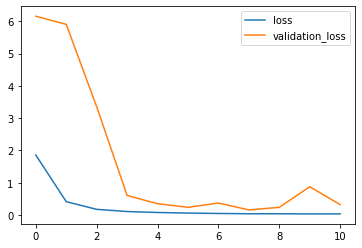

In [ ]:
plt.figure(1)
losses_df1 = pd.DataFrame({
    'loss': history3.history['loss'],
    'validation_loss': history3.history['val_loss']
})

_ = losses_df1.plot()

plt.figure(2)
losses_df1 = pd.DataFrame({
    'accuracy': np.array(history3.history['accuracy']) *100 ,
    'validation_accuracy': np.array(history3.history['val_accuracy']) *100
})

_ = losses_df1.plot()


# **شبکه 5**

In [ ]:
import cv2

def equalizeG(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  r, g, b = cv2.split(image)
  equ1 = clache.apply(np.uint8(g))
  return equ1.reshape(32, 32, 1)

def normalizationG(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,1))


(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)
********************
********************
********************
Epoch 1/20
182/182 [==============================] - 9s 48ms/step - loss: 1.8079 - accuracy: 0.5304 - val_loss: 5.0022 - val_accuracy: 0.0544
Epoch 2/20
182/182 [==============================] - 8s 46ms/step - loss: 0.3340 - accuracy: 0.9171 - val_loss: 5.5893 - val_accuracy: 0.0147
Epoch 3/20
182/182 [==============================] - 8s 46ms/step - loss: 0.1349 - accuracy: 0.9662 - val_loss: 2.8074 - val_accuracy: 0.3594
Epoch 4/20
182/182 [==============================] - 8s 46ms/step - loss: 0.0902 - accuracy: 0

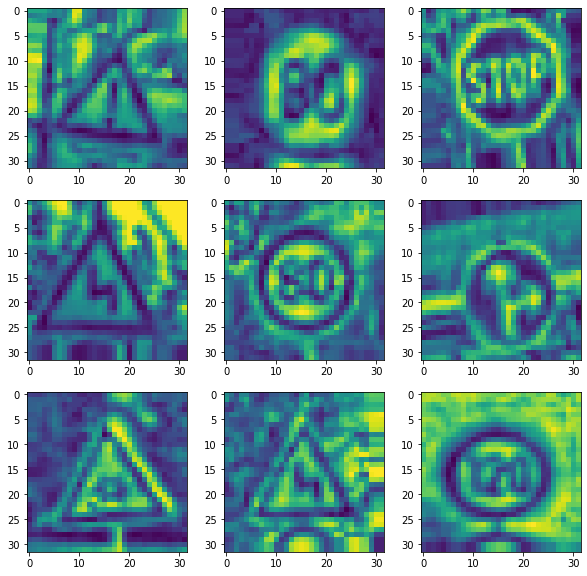

In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Histogram equalization
  equ = equalizeG(img)
  # Normalization
  normed = normalizationG(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Histogram equalization
  equ = equalizeG(img)
  # Normalization
  normed = normalizationG(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Histogram equalization
  equ = equalizeG(img)
  # Normalization
  normed = normalizationG(equ)
  tmp.append(normed)

testX = np.array(tmp)



print('*' * 20)



    
trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)


fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32)
    plt.imshow(img)
  else:
    break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history4 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

<Figure size 432x288 with 0 Axes>

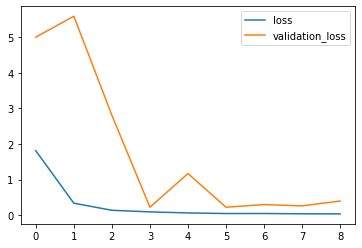

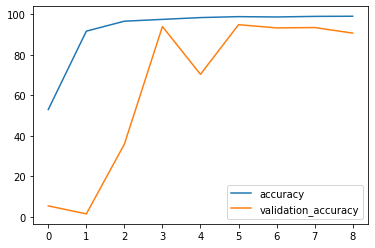

In [ ]:
plt.figure(1)
losses_df1 = pd.DataFrame({
    'loss': history4.history['loss'],
    'validation_loss': history4.history['val_loss']
})

_ = losses_df1.plot()

plt.figure(2)
losses_df1 = pd.DataFrame({
    'accuracy': np.array(history4.history['accuracy']) *100 ,
    'validation_accuracy': np.array(history4.history['val_accuracy']) *100
})

_ = losses_df1.plot()


# **6 شبکه**

In [ ]:
import cv2

def equalizeRG0(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  r, g, b = cv2.split(image)
  equ1 = clache.apply(np.uint8(r))
  equ2 = clache.apply(np.uint8(g))
  equ3 = clache.apply(np.uint8(b))
  equ = cv2.merge((equ1, equ2, equ3))
  return equ.reshape(32, 32, 3)


def to_RG0(image):
  out = [[0.0 for i in range(len(image))] for i in range(len(image))]
  qq = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      q = [image[i][j][0], image[i][j][1], 0] 
      out[i][j] = q
      if q < 1:
        qq += 1
  return np.array(out), qq


def normalizationRG0(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,3))




(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 3) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 3) testY shape:  (12630, 43)
********************
********************
********************
Epoch 1/20
182/182 [==============================] - 14s 79ms/step - loss: 1.7245 - accuracy: 0.5506 - val_loss: 4.5657 - val_accuracy: 0.0476
Epoch 2/20
182/182 [==============================] - 14s 78ms/step - loss: 0.3143 - accuracy: 0.9233 - val_loss: 3.9940 - val_accuracy: 0.1420
Epoch 3/20
182/182 [==============================] - 14s 78ms/step - loss: 0.1182 - accuracy: 0.9720 - val_loss: 0.6955 - val_accuracy: 0.8000
Epoch 4/20
182/182 [==============================] - 14s 77ms/step - loss: 0.0676 - accurac

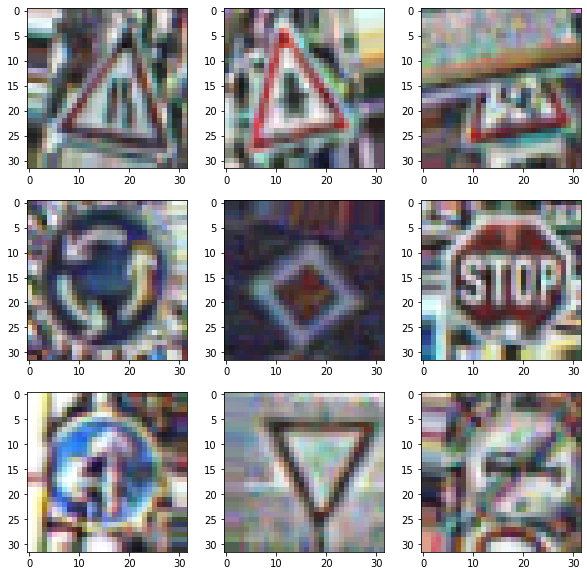

In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  # Histogram equalization
  equ = equalizeRG0(img)
  # Normalization
  normed = normalizationRG0(equ)
  tmp.append(normed)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  # Histogram equalization
  equ = equalizeRG0(img)
  # Normalization
  normed = normalizationRG0(equ)
  tmp.append(normed)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  # Histogram equalization
  equ = equalizeRG0(img)
  # Normalization
  normed = normalizationRG0(equ)
  tmp.append(normed)

testX = np.array(tmp)

print('*' * 20)


trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32, 3)
    plt.imshow(img)
  else:
    break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history5 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

<Figure size 432x288 with 0 Axes>

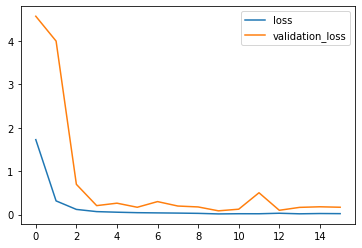

In [ ]:
plt.figure(1)
losses_df1 = pd.DataFrame({
    'loss': history5.history['loss'],
    'validation_loss': history5.history['val_loss']
})

_ = losses_df1.plot()

plt.figure(2)
losses_df1 = pd.DataFrame({
    'accuracy': np.array(history5.history['accuracy']) *100 ,
    'validation_accuracy': np.array(history5.history['val_accuracy']) *100
})

_ = losses_df1.plot()

### شبکه **7**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def to_gray(image):
  out = [[0.0 for i in range(len(image))] for i in range(len(image))]
  qq = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      q = image[i][j][0] * 0.299 + image[i][j][1] * 0.587 + image[i][j][2] * 0.114
      out[i][j] = [q]
      if q < 1:
        qq += 1
  return np.array(out), qq


def histogram_equalize(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equ = clache.apply(np.uint8(image))
  return equ


def normalization(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,1))

def negative_data(image):
 return 1 - image


(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)
********************
********************
********************
Epoch 1/20
182/182 [==============================] - 9s 47ms/step - loss: 1.6955 - accuracy: 0.5634 - val_loss: 10.4953 - val_accuracy: 0.0068
Epoch 2/20
182/182 [==============================] - 9s 47ms/step - loss: 0.3122 - accuracy: 0.9250 - val_loss: 9.4738 - val_accuracy: 0.0147
Epoch 3/20
182/182 [==============================] - 9s 47ms/step - loss: 0.1288 - accuracy: 0.9679 - val_loss: 5.4444 - val_accuracy: 0.1508
Epoch 4/20
182/182 [==============================] - 9s 47ms/step - loss: 0.0766 - accuracy: 

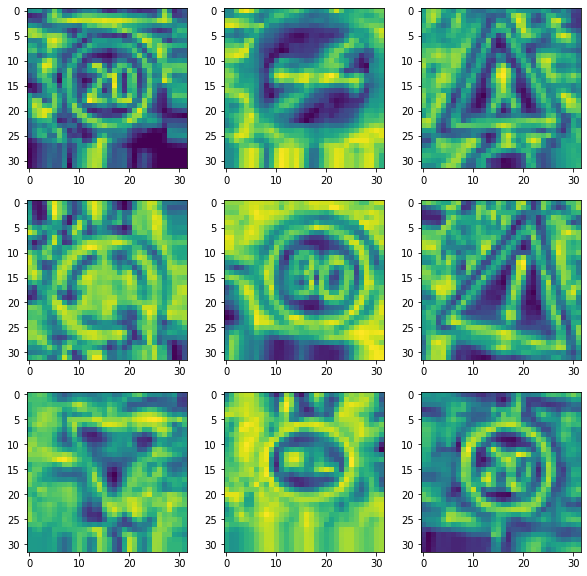

In [ ]:
# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

testX = np.array(tmp)

print('*' * 20)

trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

fig = plt.figure(figsize=(10, 10))
for i,(images,labels) in enumerate(image_data):
  if i < 9:
    fig.add_subplot(3, 3, i + 1)
    img = images[0].reshape(32, 32)
    plt.imshow(img)
  else:
    break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)

model1 = tf.keras.models.Sequential()

model1.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model1.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.AveragePooling2D((2, 2)))
model1.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Flatten())

model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.Dropout(0.25))
model1.add(tf.keras.layers.Dense(128, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(64, activation='relu'))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(43, activation='softmax'))

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

history6 = model1.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

In [ ]:
model1.save("negativedata_model.h5")

In [ ]:
history6.history 

{'accuracy': [0.49961239099502563,
  0.8998708128929138,
  0.9589577913284302,
  0.9777346849441528,
  0.9849698543548584,
  0.9862618446350098,
  0.9900947213172913,
  0.9897502064704895,
  0.9900947213172913,
  0.9922911524772644,
  0.9943152666091919],
 'loss': [1.9147908687591553,
  0.399056077003479,
  0.15826214849948883,
  0.0865955650806427,
  0.058549925684928894,
  0.050542354583740234,
  0.03704976290464401,
  0.03813124820590019,
  0.03295329585671425,
  0.028286853805184364,
  0.020782798528671265],
 'val_accuracy': [0.020408162847161293,
  0.02154194936156273,
  0.14058956503868103,
  0.9063491821289062,
  0.8596372008323669,
  0.7866213321685791,
  0.9546485543251038,
  0.9689342379570007,
  0.9528344869613647,
  0.9340136051177979,
  0.9664399027824402],
 'val_loss': [6.183840274810791,
  5.890844821929932,
  4.298919677734375,
  0.3217320740222931,
  0.5149709582328796,
  1.0172221660614014,
  0.17284567654132843,
  0.11255467683076859,
  0.20168478786945343,
  0.24782

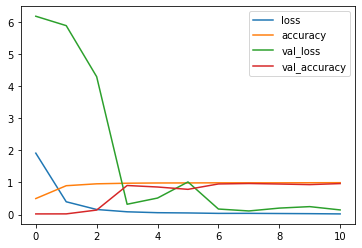

In [ ]:
df = pd.DataFrame(history6.history)
df.plot()


# **شبکه 8**

In [ ]:
# The classes have diffrent number of images so we do this 
y = np.array(y)
mean_class_count = y.sum() // len(y)
print('mean:', mean_class_count)
sec_quantile_class_count = int(np.quantile(y, .50))
print('quatile:', sec_quantile_class_count)

# I choose sec_quantile_class_count
class_count = mean_class_count
print('miangin:', class_count)

# load train to dict
tmp = {}
for i in classes:
  tmp[str(i)] = []

for index, img in enumerate(train_dict['features']):
  tmp[str(train_dict['labels'][index])].append(img)

train_data = tmp

for _class, images in train_data.items():
  l = len(images)
  l1 = l
  while l1 < class_count:
    print('images size before make duplicates:', l1)
    train_data[_class] = np.concatenate((train_data[_class], images), axis=0)
    l1 += l
  np.random.shuffle(train_data[_class])
  train_data[_class] = np.array(train_data[_class][:class_count])

for _class, images in train_data.items():
  print('class', _class, 'have', len(images), 'images with shape', images.shape)

mean: 809
quatile: 540
miangin: 809
images size before make duplicates: 180
images size before make duplicates: 360
images size before make duplicates: 540
images size before make duplicates: 720
images size before make duplicates: 360
images size before make duplicates: 720
images size before make duplicates: 690
images size before make duplicates: 540
images size before make duplicates: 360
images size before make duplicates: 720
images size before make duplicates: 180
images size before make duplicates: 360
images size before make duplicates: 540
images size before make duplicates: 720
images size before make duplicates: 300
images size before make duplicates: 600
images size before make duplicates: 270
images size before make duplicates: 540
images size before make duplicates: 330
images size before make duplicates: 660
images size before make duplicates: 450
images size before make duplicates: 240
images size before make duplicates: 480
images size before make duplicates: 720
imag

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def to_gray(image):
  out = [[0.0 for i in range(len(image))] for i in range(len(image))]
  qq = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      q = image[i][j][0] * 0.299 + image[i][j][1] * 0.587 + image[i][j][2] * 0.114
      out[i][j] = [q]
      if q < 1:
        qq += 1
  return np.array(out), qq


def histogram_equalize(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equ = clache.apply(np.uint8(image))
  return equ


def normalization(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,1))

def negative_data(image):
 return 1 - image


# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

testX = np.array(tmp)

print('*' * 20)

trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

# fig = plt.figure(figsize=(10, 10))
# for i,(images,labels) in enumerate(image_data):
#   if i < 9:
#     fig.add_subplot(3, 3, i + 1)
#     img = images[0].reshape(32, 32)
#     plt.imshow(img)
#   else:
#     break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)


(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)
********************
********************
********************


In [ ]:
model2 = tf.keras.models.Sequential()

model2.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model2.add(tf.keras.layers.Conv2D(32, (5, 5)))
model2.add(tf.keras.layers.ReLU())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same'))
model2.add(tf.keras.layers.ReLU())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.MaxPooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same'))
model2.add(tf.keras.layers.ReLU())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same'))
model2.add(tf.keras.layers.ReLU())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.AveragePooling2D((2, 2)))
model2.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same'))
model2.add(tf.keras.layers.ReLU())
model2.add(tf.keras.layers.BatchNormalization())

model2.add(tf.keras.layers.Flatten())

model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.25))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(43, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

history2 = model2.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

Epoch 1/20
182/182 [==============================] - 9s 47ms/step - loss: 1.9087 - accuracy: 0.5059 - val_loss: 4.2365 - val_accuracy: 0.0209
Epoch 2/20
182/182 [==============================] - 8s 47ms/step - loss: 0.3416 - accuracy: 0.9177 - val_loss: 5.4841 - val_accuracy: 0.0508
Epoch 3/20
182/182 [==============================] - 8s 46ms/step - loss: 0.1372 - accuracy: 0.9653 - val_loss: 2.0876 - val_accuracy: 0.5152
Epoch 4/20
182/182 [==============================] - 9s 48ms/step - loss: 0.0732 - accuracy: 0.9824 - val_loss: 0.2990 - val_accuracy: 0.9111
Epoch 5/20
182/182 [==============================] - 9s 47ms/step - loss: 0.0551 - accuracy: 0.9863 - val_loss: 0.2042 - val_accuracy: 0.9397
Epoch 6/20
182/182 [==============================] - 8s 47ms/step - loss: 0.0477 - accuracy: 0.9869 - val_loss: 0.1483 - val_accuracy: 0.9658
Epoch 7/20
182/182 [==============================] - 8s 47ms/step - loss: 0.0374 - accuracy: 0.9896 - val_loss: 0.1122 - val_accuracy: 0.9726

In [ ]:
model2.summary()
model2.save('best.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 64)        51264     
_________________________________________________________________
re_lu_6 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)      

<Figure size 432x288 with 0 Axes>

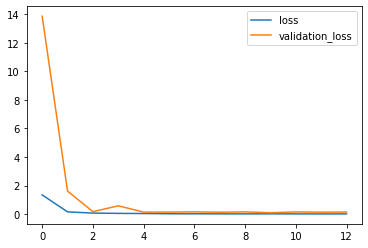

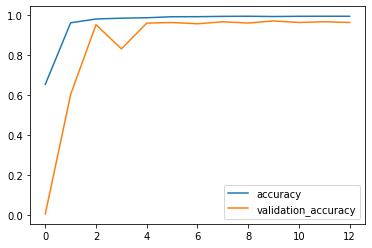

In [ ]:
losses_df = pd.DataFrame({
    'loss': history2.history['loss'],
    'validation_loss': history2.history['val_loss']
})
plt.figure(1)
_ = losses_df.plot()

plt.savefig('loss.png')

accuracy_df = pd.DataFrame({
    'accuracy': history2.history['accuracy'],
    'validation_accuracy': history2.history['val_accuracy']
})
_ = plt.figure(2)
_ = accuracy_df.plot()

plt.savefig('accuracy.png')

In [ ]:
layer_names = []
for layer in model2.layers[:17]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

layer_names

['conv2d_14',
 're_lu_9',
 'batch_normalization_20',
 'conv2d_15',
 're_lu_10',
 'batch_normalization_21',
 'max_pooling2d_4',
 'conv2d_16',
 're_lu_11',
 'batch_normalization_22',
 'conv2d_17',
 're_lu_12',
 'batch_normalization_23',
 'average_pooling2d_2',
 'conv2d_18',
 're_lu_13',
 'batch_normalization_24']

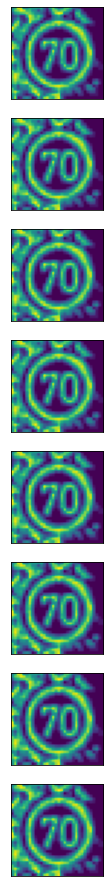

In [ ]:
sample_index = 1100

sample = validX[sample_index]
class_id = np.where(validY[sample_index] == 1)[0][0]
tmp = labels[labels.ClassId == class_id].SignName.values[0]

limit = 8
w_h = (5, 16)
counter = 1

fig = plt.figure(figsize=w_h)
for i in range(limit):
  ax = fig.add_subplot(limit, 1, i + 1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(sample.reshape(32, 32))

plt.savefig('{}.png'.format(counter))
counter += 1

layer : conv2d_14 , feature map shape : (1, 28, 28, 32)
filters shape : (5, 5, 1, 32)
layer : re_lu_9 , feature map shape : (1, 28, 28, 32)
layer : conv2d_15 , feature map shape : (1, 28, 28, 64)
filters shape : (5, 5, 32, 64)
layer : re_lu_10 , feature map shape : (1, 28, 28, 64)
layer : max_pooling2d_4 , feature map shape : (1, 14, 14, 64)
layer : conv2d_16 , feature map shape : (1, 14, 14, 64)
filters shape : (5, 5, 64, 64)
layer : re_lu_11 , feature map shape : (1, 14, 14, 64)
layer : conv2d_17 , feature map shape : (1, 14, 14, 64)
filters shape : (5, 5, 64, 64)
layer : re_lu_12 , feature map shape : (1, 14, 14, 64)
layer : average_pooling2d_2 , feature map shape : (1, 7, 7, 64)
layer : conv2d_18 , feature map shape : (1, 7, 7, 64)
filters shape : (5, 5, 64, 64)
layer : re_lu_13 , feature map shape : (1, 7, 7, 64)


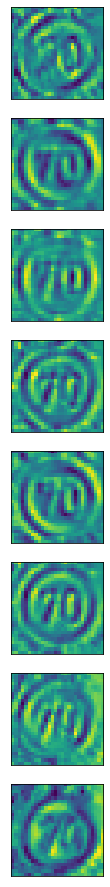

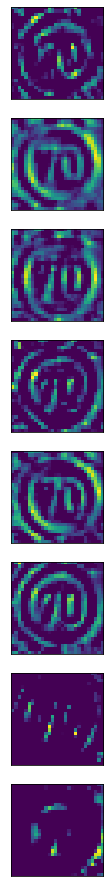

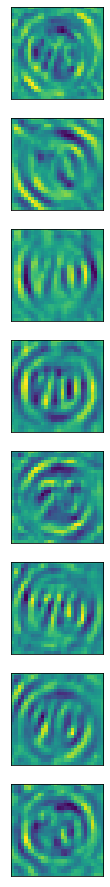

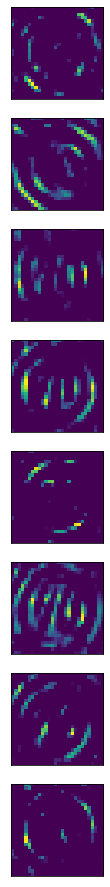

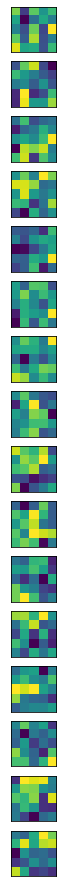

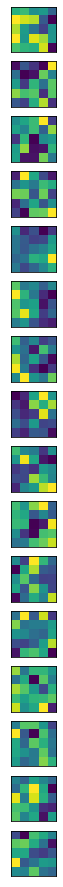

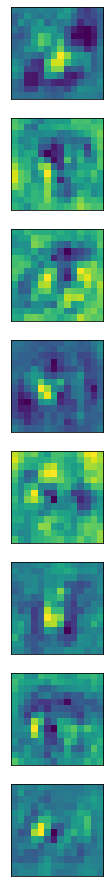

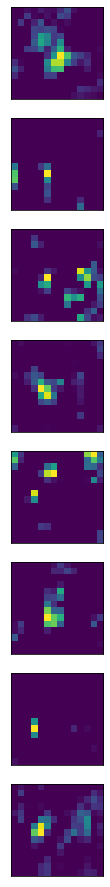

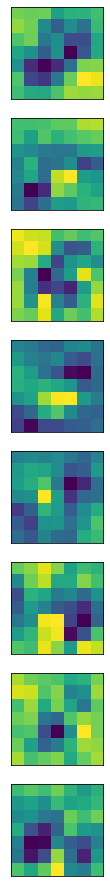

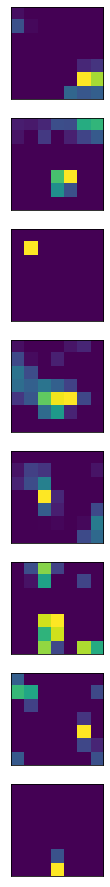

In [ ]:
tf.get_logger().setLevel('CRITICAL')

filters_fig_size = w_h
filters_limit = 16

for i, layer in enumerate(model2.layers[:17]):
  if 'batch' in layer_names[i]:
    continue
  model_layer = tf.keras.models.Model(inputs=model2.inputs, outputs=model2.layers[i].output)
  feature_maps = model_layer.predict(sample.reshape(1, 32, 32, 1))
  print('layer : {} , feature map shape : {}'.format(model2.layers[i].name, feature_maps.shape))
  if 'conv' in layer_names[i]:
    fig = plt.figure(figsize=filters_fig_size)
    filters, bias = layer.get_weights()
    print('filters shape : {}'.format(filters.shape))
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    for j in range(filters_limit):
      f = filters[:, :, 0, j]
      ax = fig.add_subplot(filters_limit, 1, j + 1)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(f)
    plt.savefig('{}.png'.format(counter))
    counter += 1
  fig = plt.figure(figsize=w_h)
  for j in range(limit):
    ax = fig.add_subplot(limit, 1, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(feature_maps[0, :, :, j])
  plt.savefig('{}.png'.format(counter))
  counter += 1
  

tf.get_logger().setLevel('DEBUG')

real class: Vehicles over 3.5 metric tons prohibited
1/1 [==============================] - 0s 2ms/step
predicted class: Vehicles over 3.5 metric tons prohibited


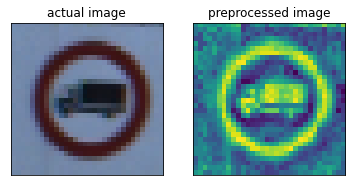

In [ ]:
#  Print a sample of test data

def get_class_from_id(class_id_categorical):
  class_id = np.argmax(class_id_categorical)
  return labels[labels.ClassId == class_id].SignName.values[0]

sampleX = testX[0]
sampleY = testY[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1)
_ = plt.imshow(test_dict['features'][0].reshape(32, 32, 3))
ax.title.set_text('actual image')
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 2, 2)
_ = plt.imshow(sampleX.reshape(32, 32))
ax.title.set_text('preprocessed image')
ax.set_xticks([])
ax.set_yticks([])
print('real class:', get_class_from_id(sampleY))


predicted = model2.predict(sampleX.reshape(1, 32, 32, 1), verbose=1)
print('predicted class:', get_class_from_id(predicted))


In [ ]:
model2.save('best_model.h5')

In [ ]:
print(testX.shape)
print(testY.shape)

predicts = model2.predict(testX, verbose=1)

orderd_predicted = []
tmp = []
for i, predict in enumerate(predicts):
  tmp.append(get_class_from_id(testY[i]))
  orderd_predicted.append(get_class_from_id(predict))

tmp = np.array(tmp)
orderd_predicted = np.array(orderd_predicted)

(12630, 32, 32, 1)
(12630, 43)
395/395 [==============================] - 1s 3ms/step


In [ ]:
pred_df = pd.DataFrame({
    'real_lable': tmp,
    'predicted_label': orderd_predicted
})

pred_df

real_lable                               predicted_label
0          Vehicles over 3.5 metric tons prohibited      Vehicles over 3.5 metric tons prohibited
1                              Speed limit (30km/h)                          Speed limit (30km/h)
2                                        Keep right                                    Keep right
3                                  Turn right ahead                              Turn right ahead
4             Right-of-way at the next intersection         Right-of-way at the next intersection
...                                             ...                                           ...
12625                                 Priority road                                 Priority road
12626                              Turn right ahead                              Turn right ahead
12627                   End of speed limit (80km/h)                   End of speed limit (80km/h)
12628                         Speed limit (100km/h)                         Speed limit (100km/h)
12629  No passing for vehicles over 3.5 metric tons  No passing for vehicles over 3.5 metric tons

[12630 rows x 2 columns]

In [ ]:
accuracy = 0
wrongs = []
for index, row in pred_df.iterrows():
  if row['real_lable'] == row['predicted_label']:
    accuracy += 1
  else:
    wrongs.append((index, row['real_lable'], row['predicted_label']))

print('test set accuracy:{:.2f}'.format(accuracy / len(pred_df) * 100))

test set accuracy:96.13


In [ ]:
print('number of wrong data:', len(wrongs), 'out of', len(pred_df))
wrong_dict = {}
for i in wrongs:
  tmp = wrong_dict.get(i[1], [])
  tmp.append((i[0], i[2]))
  wrong_dict[i[1]] = tmp

x = []
y = []

for i, j in wrong_dict.items():
  x.append(i)
  y.append(len(j))

n = len(y)
for i in range(n-1):
  for j in range(0, n-i-1): 
    if y[j] > y[j+1] : 
      y[j], y[j+1] = y[j+1], y[j]
      x[j], x[j+1] = x[j+1], x[j]

fig = plt.figure(figsize=(6, 10))
fig.add_subplot(1, 1, 1)
_ = plt.barh(x, y)

number of wrong data: 489 out of 12630


[]

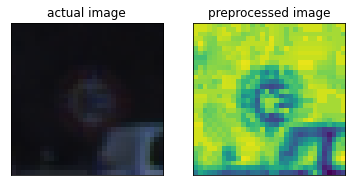

In [ ]:
# Draw one sample wrong data
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1)
index, sample = wrong_dict['Speed limit (80km/h)'][0]
ax.title.set_text('actual image')
_ = plt.imshow(test_dict['features'][index].reshape(32, 32, 3))
ax.set_xticks([])
ax.set_yticks([])
ax = fig.add_subplot(1, 2, 2)
ax.title.set_text('preprocessed image')
_ = plt.imshow(testX[index].reshape(32, 32))
ax.set_xticks([])
ax.set_yticks([])

# End of work
from this point below is just for better undrestading (doing all this in a little network)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def to_gray(image):
  out = [[0.0 for i in range(len(image))] for i in range(len(image))]
  qq = 0
  for i in range(len(image)):
    for j in range(len(image[i])):
      q = image[i][j][0] * 0.299 + image[i][j][1] * 0.587 + image[i][j][2] * 0.114
      out[i][j] = [q]
      if q < 1:
        qq += 1
  return np.array(out), qq


def histogram_equalize(image):
  clache = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equ = clache.apply(np.uint8(image))
  return equ


def normalization(image):
  image = np.float32(image)
  norm = image / 255.0
  return np.reshape(norm, (32,32,1))

def negative_data(image):
 return 1 - image


# Make a ndarray of image datas
trainX = []
trainY = []
for _class, images in train_data.items():
  trainX = trainX + images.tolist()
  trainY = trainY + [float(_class) for i in range(class_count)]

trainX = np.array(trainX)
trainY = np.array(trainY)

print(trainX.shape)
print(trainY.shape)

print('*' * 20)

## Train data
print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
tmp = []
for img in trainX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

trainX = np.array(tmp)

## Validation data
validX = valid_dict['features']
validY = valid_dict['labels']
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
tmp = []
for img in validX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

validX = np.array(tmp)

## Test data
testX = test_dict['features']
testY = test_dict['labels']
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)
tmp = []
for img in testX:
  #Grayscaling
  gray,_ = to_gray(img)
  # Histogram equalization
  equ = histogram_equalize(gray)
  # Normalization
  normed = normalization(equ)
  # negative_dat
  neg = negative_data(normed)
  tmp.append(neg)

testX = np.array(tmp)

print('*' * 20)

trainY = tf.keras.utils.to_categorical(trainY, len(classes))
validY = tf.keras.utils.to_categorical(validY, len(classes))
testY = tf.keras.utils.to_categorical(testY, len(classes))

print('trainX shape:', trainX.shape, 'trainY shape: ', trainY.shape)
print('validX shape:', validX.shape, 'validY shape: ', validY.shape)
print('testX shape:', testX.shape, 'testY shape: ', testY.shape)


print('*' * 20)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert from integers to floats
trainX = trainX.astype('float32')

datagen = ImageDataGenerator(
        validation_split = 0.3,
        featurewise_center=False,                 # set input mean to 0 over the dataset
        samplewise_center=False,                  # set each sample mean to 0
        featurewise_std_normalization=False,      # divide inputs by std of the dataset
        samplewise_std_normalization=False,       # divide each input by its std
        zca_whitening=False,                      # apply ZCA whitening
        rotation_range=10,                        # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                         # Randomly zoom image 
        width_shift_range=0.1,                    # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                   # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                    # randomly flip images
        vertical_flip=False                       # randomly flip images
)

batch_size = 128
image_data = datagen.flow(
    trainX,
    y=trainY,
    batch_size = batch_size
)

print('*' * 20)

# fig = plt.figure(figsize=(10, 10))
# for i,(images,labels) in enumerate(image_data):
#   if i < 9:
#     fig.add_subplot(3, 3, i + 1)
#     img = images[0].reshape(32, 32)
#     plt.imshow(img)
#   else:
#     break

print('*' * 20)

batch_size = 128
validation_data = datagen.flow(
    validX,
    y=validY,
    batch_size = batch_size
)



(23220, 32, 32, 3)
(23220,)
********************
trainX shape: (23220, 32, 32, 3) trainY shape:  (23220,)
validX shape: (4410, 32, 32, 3) validY shape:  (4410,)
testX shape: (12630, 32, 32, 3) testY shape:  (12630,)
********************
trainX shape: (23220, 32, 32, 1) trainY shape:  (23220, 43)
validX shape: (4410, 32, 32, 1) validY shape:  (4410, 43)
testX shape: (12630, 32, 32, 1) testY shape:  (12630, 43)
********************
********************
********************


In [ ]:
model5 = tf.keras.models.Sequential()

model5.add(tf.keras.layers.InputLayer((trainX.shape[1],trainX.shape[2],trainX.shape[3])))

model5.add(tf.keras.layers.Conv2D(8, (5, 5), padding='valid'))
model5.add(tf.keras.layers.ReLU())
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.Conv2D(16, (5, 5), padding='same'))
model5.add(tf.keras.layers.ReLU())
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.MaxPooling2D())

model5.add(tf.keras.layers.Flatten())

model5.add(tf.keras.layers.Dense(128, activation='relu'))
model5.add(tf.keras.layers.Dropout(0.25))
model5.add(tf.keras.layers.Dense(64, activation='relu'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.Dense(43, activation='softmax'))

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=3,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

history5 = model5.fit(
  image_data,
  validation_data=validation_data,
  epochs= 20,
  verbose=1,
  callbacks=[es]
)

Epoch 1/20
182/182 [==============================] - 7s 38ms/step - loss: 2.5002 - accuracy: 0.3449 - val_loss: 4.4250 - val_accuracy: 0.0068
Epoch 2/20
182/182 [==============================] - 7s 38ms/step - loss: 1.1353 - accuracy: 0.6805 - val_loss: 4.4902 - val_accuracy: 0.0120
Epoch 3/20
182/182 [==============================] - 7s 38ms/step - loss: 0.6733 - accuracy: 0.8085 - val_loss: 1.6555 - val_accuracy: 0.5351
Epoch 4/20
182/182 [==============================] - 7s 38ms/step - loss: 0.4876 - accuracy: 0.8607 - val_loss: 0.6361 - val_accuracy: 0.7995
Epoch 5/20
182/182 [==============================] - 7s 38ms/step - loss: 0.3851 - accuracy: 0.8866 - val_loss: 0.4706 - val_accuracy: 0.8585
Epoch 6/20
182/182 [==============================] - 7s 38ms/step - loss: 0.3245 - accuracy: 0.9052 - val_loss: 0.4159 - val_accuracy: 0.8753
Epoch 7/20
182/182 [==============================] - 7s 37ms/step - loss: 0.2890 - accuracy: 0.9128 - val_loss: 0.3456 - val_accuracy: 0.8950

In [ ]:
layer_names = []
non_batch_layers = 0
for layer in model5.layers[:7]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    if 'batch' not in layer.name:
      non_batch_layers += 1

layer_names

['conv2d_2',
 're_lu_2',
 'batch_normalization_3',
 'conv2d_3',
 're_lu_3',
 'batch_normalization_4',
 'max_pooling2d_1']

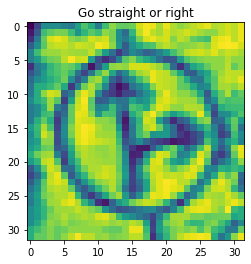

In [ ]:
sample_index = 150

sample = validX[sample_index]
_ = plt.imshow(sample.reshape(32, 32))
class_id = np.where(validY[sample_index] == 1)[0][0]
tmp = labels[labels.ClassId == class_id].SignName.values[0]
_ = plt.title(tmp)

layer : conv2d_2 , feature map shape : (1, 28, 28, 8)
filters shape : (5, 5, 1, 8)
layer : re_lu_2 , feature map shape : (1, 28, 28, 8)
layer : conv2d_3 , feature map shape : (1, 28, 28, 16)
filters shape : (5, 5, 8, 16)
layer : re_lu_3 , feature map shape : (1, 28, 28, 16)
layer : max_pooling2d_1 , feature map shape : (1, 14, 14, 16)


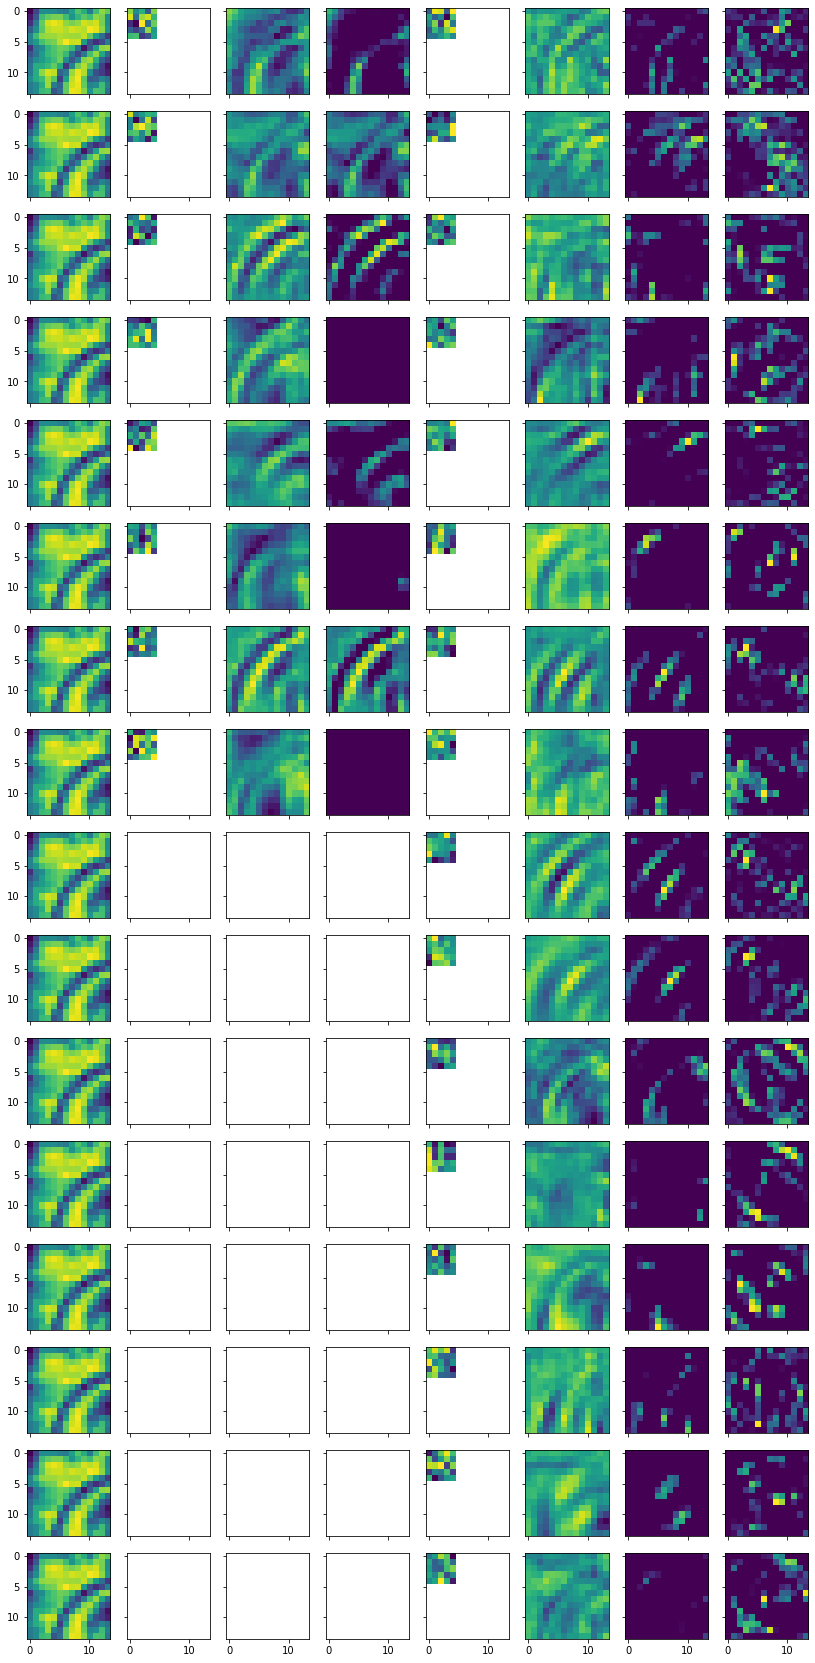

In [ ]:
tf.get_logger().setLevel('CRITICAL')

max_filter_depth = 16

fig, axs = plt.subplots(max_filter_depth, 8, figsize=(14, 30), sharex=True, sharey=True)

for i in range(max_filter_depth):
  axs[i, 0].imshow(sample.reshape(32, 32), interpolation='nearest', aspect='auto')

col = 1
for i, layer in enumerate(model5.layers[:7]):
  if 'batch' in layer_names[i]:
    continue
  model_layer = tf.keras.models.Model(inputs=model5.inputs, outputs=model5.layers[i].output)
  feature_maps = model_layer.predict(sample.reshape(1, 32, 32, 1))
  print('layer : {} , feature map shape : {}'.format(model5.layers[i].name, feature_maps.shape))
  if 'conv' in layer_names[i]:
    filters, bias = layer.get_weights()
    print('filters shape : {}'.format(filters.shape))
    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    n_filters = filters.shape[3]
    for j in range(n_filters):
      f = filters[:, :, 0, j]
      axs[j, col].imshow(f, interpolation='nearest', aspect='auto')
    col += 1
  ix = 0
  for _ in range(feature_maps.shape[-1]):
    axs[ix, col].imshow(feature_maps[0, :, :, ix-1], interpolation='nearest', aspect='auto')
    ix += 1
  col += 1


tf.get_logger().setLevel('DEBUG')